In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import ast

In [2]:
# load in atbats
first_base = pd.read_csv('atbats_total.csv')

first_base['runner_id'] = first_base['dict_players'].apply(lambda x: list(ast.literal_eval(x).keys())[-1])
# load in stolen bases
stolen_df = pd.read_csv('stolen_df_2.csv')

stolen_df.sort_values(by='Date')

data_exp = {
    "Runners": ['0', "1", "2", "1,2", "3", "1,3", "2,3", "1,2,3"],
    "0 Outs": [0.461, 0.831, 1.068, 1.373, 1.426, 1.798, 1.920, 2.282],
    "1 Outs": [0.243, 0.489, 0.644, 0.908, 0.865, 1.140, 1.352, 1.520],
    "2 Outs": [0.095, 0.214, 0.305, 0.343, 0.413, 0.471, 0.570, 0.736],
}


exp_run_base = pd.DataFrame(data_exp)

stolen_subset = stolen_df[['Result', 'Date', 'runner_id']]

# merge datasets on id and date

final_df = pd.merge(stolen_subset, first_base, on=['Date', 'runner_id'], how='inner')

final_df.sort_values(by='Date')

,Result,Date,runner_id,Unnamed: 0,Batter_name,Rbi_outcome,Rbi_stay,Success_past,Success_past_third,Success_past_second,Outs,homeScore,awayScore,inning,isTopInning,Isout,Current_outs,dict_players
61061,1,2016-04-02,485567,65999,Darwin Barney,1,0,0.200000,0.833333,0.200000,3,2,0,4,False,True,1,"{'init': 0, 485567: 1}"
61059,1,2016-04-02,485567,65999,Darwin Barney,1,0,0.200000,0.833333,0.200000,3,2,0,4,False,True,1,"{'init': 0, 485567: 1}"
61060,1,2016-04-02,485567,65999,Darwin Barney,1,0,0.200000,0.833333,0.200000,3,2,0,4,False,True,1,"{'init': 0, 485567: 1}"
61052,1,2016-04-08,572821,66800,Danny Santana,0,0,0.233333,0.566667,0.233333,1,0,0,1,True,True,1,"{'init': 0, 572821: 1}"
61051,1,2016-04-08,572821,66792,Danny Santana,1,0,0.233333,0.566667,0.233333,3,2,1,5,True,True,1,"{'init': 0, 572821: 1}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25537,1,2023-09-30,664901,333916,Ronny Mauricio,0,0,0.333333,0.700000,0.333333,2,4,0,7,False,True,1,"{'init': 0, 664901: 1}"
25538,1,2023-09-30,664901,333917,Rafael Ortega,0,0,0.266667,0.700000,0.266667,1,4,0,7,False,True,1,"{'init': 0, 664901: 1}"
25539,1,2023-09-30,596019,333914,DJ Stewart,0,0,0.233333,0.700000,0.233333,2,4,1,8,False,True,0,"{'init': 0, 596019: 1}"
25532,0,2023-09-30,677951,333992,Salvador Perez,1,1,0.233333,0.733333,0.233333,1,2,0,3,False,False,1,"{'init': 0, 677951: 1}"


In [3]:
final_df['Rbi_steal_unique'] = final_df.apply(lambda x: 1 if x['Rbi_outcome'] == 1 and x['Rbi_stay'] == 0 else 0, axis=1)

In [4]:
# list for successful steals

succes_steal = []

# iterate through df to obtain past successful steals

for row, i in final_df.iterrows():
    
    runner_id = i['runner_id']
    
    results = stolen_df.loc[(stolen_df['Date'] < i['Date']) & (stolen_df['runner_id'] == runner_id)].tail(10)['Result'].tolist()
    
    if len(results) < 10:
        succes_steal.append(np.nan)
        
    else:
        succes_steal.append(sum(results) / 10)

# documents percentage of successful steals        
final_df['Past_Steal_Success'] = succes_steal

final_df['Simulated_out'] = final_df['Current_outs'] + 1

In [5]:
# calculating utility if stolen, caught, and stays
# success_steal is the pecerntage of rbis the batter has hit at the next base and success_stay is rbis hit at current base

# diff in scores
final_df['Diff'] = final_df.apply(lambda x: x['awayScore'] - x['homeScore'] if x['isTopInning'] == 1 else x['homeScore'] - x['awayScore'], axis=1)

# re weight distribution so lower scores ex -1 and 1 have higher weight
final_df['Diff_transform'] = final_df['Diff'].apply(lambda x: np.exp(-(x**2) / (2 * (1.5)**2)))

final_df['Utility_steal'] = final_df.apply(lambda x: x['Past_Steal_Success'] * x['Success_past_third'] * (exp_run_base.loc[(exp_run_base['Runners'] == "3")][f'{x["Current_outs"]} Outs'].tolist()[0]), axis=1)

final_df['Utility_caught'] = final_df.apply(lambda x: (1 - x['Past_Steal_Success']) * (0 - exp_run_base.loc[(exp_run_base['Runners'] == "2")][f'{x["Current_outs"]} Outs'].tolist()[0]) if x["Simulated_out"] == 3 else (1 - x['Past_Steal_Success']) * (exp_run_base.loc[(exp_run_base['Runners'] == "0")][f'{x["Simulated_out"]} Outs'].tolist()[0] - exp_run_base.loc[(exp_run_base['Runners'] == "2")][f'{x["Current_outs"]} Outs'].tolist()[0]), axis=1)

final_df['Utility_stay'] = final_df.apply(lambda x: (x['Success_past_second']) * (exp_run_base.loc[(exp_run_base['Runners'] == "2")][f'{x["Current_outs"]} Outs'].tolist()[0]), axis=1)


In [6]:
final_df.dropna(inplace=True)
final_df.head()

,Result,Date,runner_id,Unnamed: 0,Batter_name,Rbi_outcome,Rbi_stay,Success_past,Success_past_third,Success_past_second,...,Current_outs,dict_players,Rbi_steal_unique,Past_Steal_Success,Simulated_out,Diff,Diff_transform,Utility_steal,Utility_caught,Utility_stay
0,1,2021-04-01,545341,225604,Danny Jansen,1,0,0.300000,0.833333,0.300000,...,1,"{'init': 0, 545341: 1}",1,0.7,2,0,1.0,0.504583,-0.1647,0.193200
1,1,2021-04-01,545341,225605,Marcus Semien,0,0,0.233333,0.600000,0.233333,...,1,"{'init': 0, 545341: 1}",0,0.7,2,0,1.0,0.363300,-0.1647,0.150267
2,1,2021-04-01,545341,225604,Danny Jansen,1,0,0.300000,0.833333,0.300000,...,1,"{'init': 0, 545341: 1}",1,0.7,2,0,1.0,0.504583,-0.1647,0.193200
3,1,2021-04-01,545341,225605,Marcus Semien,0,0,0.233333,0.600000,0.233333,...,1,"{'init': 0, 545341: 1}",0,0.7,2,0,1.0,0.363300,-0.1647,0.150267
4,1,2021-04-01,545341,225604,Danny Jansen,1,0,0.300000,0.833333,0.300000,...,1,"{'init': 0, 545341: 1}",1,0.7,2,0,1.0,0.504583,-0.1647,0.193200


In [7]:
# expected utility equation
final_df['Expected_Utils'] = final_df['Utility_steal'] * final_df['Diff_transform'] * np.exp(-final_df['Current_outs']) + final_df['Utility_caught'] * np.exp(final_df['Current_outs']) * final_df['inning'] - final_df['Utility_stay'] * np.exp(-final_df['Current_outs'])



# Equation

- exp(- current outs) puts more weight on less outs
- exp(current outs) puts more weight on more outs

Utility steal * diff in score * exp(- current outs) + Utility caught * exp(current outs) * inning - Utility stay * exp(- current outs

In [8]:
final_df = final_df.sort_values(by='Expected_Utils')
final_df = final_df.reset_index()

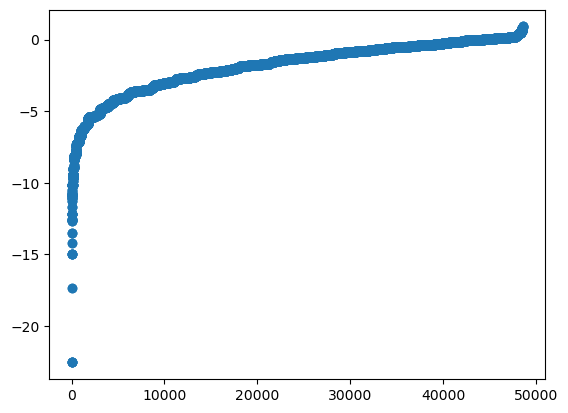

In [9]:
plt.scatter(x=final_df.index, y=final_df['Expected_Utils'])

In [10]:
# Above -1 util threshold

total_obs = len(final_df.loc[final_df['Expected_Utils'] > -1])
rbi_outcomes = final_df.loc[final_df['Expected_Utils'] > -1]['Rbi_steal_unique'].sum()
rbi_outcomes_stay = final_df.loc[final_df['Expected_Utils'] > -1]['Rbi_stay'].sum()
past_success_steal_prob = final_df.loc[final_df['Expected_Utils'] > -1]['Past_Steal_Success'].mean()

print(f'''Total Obs - {total_obs} with rbi outcomes - {rbi_outcomes} and prob of success of steal- {past_success_steal_prob} means that there is an  expected rbi return of {rbi_outcomes * past_success_steal_prob } this means you can expect a gain of {rbi_outcomes * past_success_steal_prob - rbi_outcomes_stay} RBis by choosing steal

With percentage of rbis gained per attempted steal - {rbi_outcomes * past_success_steal_prob / total_obs}''')


Total Obs - 20292 with rbi outcomes - 6806 and prob of success of steal- 0.8254336684406941 means that there is an  expected rbi return of 5617.901547407364 this means you can expect a gain of 2028.901547407364 RBis by choosing steal

With percentage of rbis gained per attempted steal - 0.27685302323119276


In [11]:
# Less than -1 threshold

total_obs = len(final_df.loc[final_df['Expected_Utils'] < -1])

rbi_outcomes = final_df.loc[final_df['Expected_Utils'] < -1]['Rbi_steal_unique'].sum()
rbi_outcomes_stay = final_df.loc[final_df['Expected_Utils'] < -1]['Rbi_stay'].sum()
past_success_steal_prob = final_df.loc[final_df['Expected_Utils'] < -1]['Past_Steal_Success'].mean()

print(f'''Total Obs - {total_obs} with rbi outcomes - {rbi_outcomes} and prob of success of steal- {past_success_steal_prob} means that there is an  expected rbi return of {rbi_outcomes * past_success_steal_prob } this means you can expect a gain of {rbi_outcomes * past_success_steal_prob - rbi_outcomes_stay} RBis by choosing steal or by choosing to stay gain {rbi_outcomes_stay} rbis

With percentage of rbis gained per attempted steal - {rbi_outcomes * past_success_steal_prob / total_obs}''')


Total Obs - 28271 with rbi outcomes - 9555 and prob of success of steal- 0.6738106186551871 means that there is an  expected rbi return of 6438.260461250313 this means you can expect a gain of 1629.2604612503128 RBis by choosing steal or by choosing to stay gain 4809 rbis

With percentage of rbis gained per attempted steal - 0.22773373638181574


In [17]:
dict_hist = {}

for i in np.arange(-3, 1, 0.1):
    
    # Less than -1 threshold

    total_obs = len(final_df.loc[final_df['Expected_Utils'] > i])

    rbi_outcomes = final_df.loc[final_df['Expected_Utils'] > i]['Rbi_steal_unique'].sum()
    rbi_outcomes_stay = final_df.loc[final_df['Expected_Utils'] > i]['Rbi_stay'].sum()
    past_success_steal_prob = final_df.loc[final_df['Expected_Utils'] > i]['Past_Steal_Success'].mean()
    
    dict_hist[i] = {}
    
    dict_hist[i]['Expected_RBI_Return'] = rbi_outcomes * past_success_steal_prob
    
    dict_hist[i]['Exp_Gain'] = rbi_outcomes * past_success_steal_prob - rbi_outcomes_stay
    
    dict_hist[i]['Stay_RBI'] = rbi_outcomes_stay
    
    dict_hist[i]['percent_return'] = rbi_outcomes * past_success_steal_prob / total_obs
    
    dict_hist[i]['percent_return_stay'] = rbi_outcomes_stay / total_obs



In [18]:
pd.DataFrame(dict_hist).transpose()

,Expected_RBI_Return,Exp_Gain,Stay_RBI,percent_return,percent_return_stay
-3.000000e+00,10082.382945,3498.382945,6584.0,0.264463,0.172700
-2.900000e+00,9878.043675,3377.043675,6501.0,0.263787,0.173605
-2.800000e+00,9855.891328,3380.891328,6475.0,0.263809,0.173314
-2.700000e+00,9672.659822,3397.659822,6275.0,0.264772,0.171767
-2.600000e+00,9421.376832,3298.376832,6123.0,0.265668,0.172659
-2.500000e+00,9358.932252,3288.932252,6070.0,0.266249,0.172684
-2.400000e+00,9170.766438,3183.766438,5987.0,0.265773,0.173506
-2.300000e+00,8929.174743,3029.174743,5900.0,0.265820,0.175642
-2.200000e+00,8637.901941,2942.901941,5695.0,0.267353,0.176267
-2.100000e+00,8365.017293,2772.017293,5593.0,0.266309,0.178059
